In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn
import os
import sys
import importlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
sys.path.append('../../model/')
from tab_transformer_pytorch import FTTransformer
import importlib
import modelAdjustments
from modelAdjustments import Combined_Dataset, train, test, categorize_columns 
import time

In [3]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

device_in_use='cpu'

df_train = pd.read_csv('../../datasets/higgs/train.csv')
df_test = pd.read_csv('../../datasets/higgs/test.csv')
df_val = pd.read_csv('../../datasets/higgs/validation.csv') #READ FROM RIGHT SPOT

target = 'class'
cat_columns, cont_columns, unique_classes_per_column = categorize_columns(df_train, target)

if target in cont_columns:
    print("Warning: CONT ")
    cont_columns.remove(target)
elif target in cat_columns:
    print("Warning: CAT ")
    cat_columns.remove(target)

print("Target:", target)
print("Categorical: ", cat_columns, len(cat_columns))
print("Continous: ", cont_columns, len(cont_columns))
print("Unique Classes per Column: ", unique_classes_per_column)

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cat_columns + cont_columns + [target]
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print('target classes: ', target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

# label encode target...
le = LabelEncoder()
df_train[target] = le.fit_transform(df_train[target])
df_test[target] = le.fit_transform(df_test[target])
df_val[target] = le.fit_transform(df_val[target])

# ...and categorical features
for feature in cat_columns:
    # print(feature)
    df_train[feature] = le.fit_transform(df_train[feature])
    df_test[feature] = le.fit_transform(df_test[feature])
    df_val[feature] = le.fit_transform(df_val[feature])


#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns, cont_columns, target)
val_dataset = Combined_Dataset(df_val, cat_columns, cont_columns, target)
test_dataset = Combined_Dataset(df_test, cat_columns, cont_columns, target)

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

GPU is not available, using CPU instead
Target: class
Categorical:  ['jet1b-tag', 'jet2b-tag', 'jet3b-tag', 'jet4b-tag'] 4
Continous:  ['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta', 'jet1phi', 'jet2pt', 'jet2eta', 'jet2phi', 'jet3pt', 'jet3eta', 'jet3phi', 'jet4pt', 'jet4eta', 'jet4phi', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb'] 24
Unique Classes per Column:  [3, 3, 3, 3]
target classes:  [2]


In [12]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class LossFunctions(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunctions, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
def train(regression_on, dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss=0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    attention_train = []

    total_rmse = 0

    if not regression_on:
        for (cat_x, cont_x, labels) in dataloader:
            cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)
            
            print('cat train', cat_x.shape)
            print('cont train', cont_x.shape)

            predictions, attn = model(cat_x, cont_x, return_attn =True)
            loss = loss_function(predictions, labels.long())
            total_loss+=loss.item()

            #computing accuracy
            y_pred_softmax_1 = torch.softmax(predictions, dim=1)
            _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
            total_correct_1 += (y_pred_labels_1 == labels).sum().item()
            total_samples_1 += labels.size(0)
            all_targets_1.extend(labels.cpu().numpy())
            all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

            attention_train.append(attn)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss/len(dataloader)
        accuracy = total_correct_1 / total_samples_1

        return avg_loss, accuracy, attn
    
    else:
        for (cat_x, cont_x, labels) in dataloader:
            cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)

            predictions, attn = model(cat_x, cont_x, return_attn =True)

            loss = loss_function(predictions, labels.unsqueeze(1))
            total_loss+=loss.item()

            rmse_value = rmse(labels.unsqueeze(1), predictions)
            total_rmse+=rmse_value

            attention_train.append(attn)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss/len(dataloader)
        avg_rmse = total_rmse/len(dataloader)

        return avg_loss, avg_rmse, attn

def test(regression_on, dataloader, model, loss_function, device_in_use):
    model.eval()

    total_loss=0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    attention_test = []

    total_rmse = 0

    if not regression_on:
        with torch.no_grad():
            for (cat_x, cont_x, labels) in dataloader:
                cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)
                print('cat test', cat_x.shape)
                print('cont test', cont_x.shape)

                predictions, attn = model(cat_x, cont_x, return_attn =True)
                loss = loss_function(predictions, labels.long())
                
                total_loss+=loss.item()

                #computing accuracy
                y_pred_softmax_1 = torch.softmax(predictions, dim=1)
                _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
                total_correct_1 += (y_pred_labels_1 == labels).sum().item()
                total_samples_1 += labels.size(0)
                all_targets_1.extend(labels.cpu().numpy())
                all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

                attention_test.append(attn)

            avg_loss = total_loss/len(dataloader)
            accuracy = total_correct_1 / total_samples_1


            return avg_loss, accuracy, attention_test
    
    else:
        with torch.no_grad():
            for (cat_x, cont_x, labels) in dataloader:
                cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)

                predictions, attn = model(cat_x, cont_x, return_attn =True)

                loss = loss_function(predictions, labels.unsqueeze(1))
                total_loss+=loss.item()

                rmse_value = rmse(labels.unsqueeze(1), predictions)
                total_rmse+=rmse_value

                attention_test.append(attn)

            avg_loss = total_loss/len(dataloader)
            avg_rmse = total_rmse/len(dataloader)

            return avg_loss, avg_rmse, attn

cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont train torch.Size([256, 24])
cat train torch.Size([256, 4])
cont trai

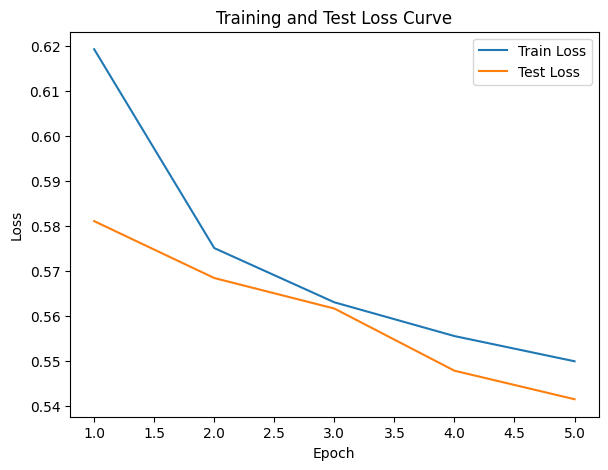

In [13]:
#Testing against the test dataset
regression_on = False

model = FTTransformer(categories=tuple(unique_classes_per_column),
                          num_continuous=len(cont_columns),
                          dim=192,
                          depth=3,
                          heads=8,
                          dim_out=target_classes[0],
                          attn_dropout=0.2,
                          ff_dropout=0.1).to(device_in_use)
loss_functions = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 0.0001, weight_decay=0.00001)
epochs = 5

train_losses = []
train_accuracies_1 = [] 

test_losses = []
test_accuracies_1 = []
  
test_f1_scores = [] 
all_attention_scores = []

#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
    train_loss, train_acc, attention_train = train(regression_on=False, 
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_functions, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc, attention_test = test(regression_on=False, dataloader=test_dataloader, model=model, loss_function=loss_functions, device_in_use=device_in_use)

    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)

    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    print(f"{epoch_str:20} | {train_metrics:65}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

In [14]:
len(attention_test)

58

In [15]:
len(attention_train)

3

In [ ]:
attention_train[1, 1, 1, :, :]

tensor([[0.0205, 0.2458, 0.0122, 0.0111, 0.0169, 0.0431, 0.0253, 0.0163, 0.0321,
         0.0093, 0.0054, 0.0377, 0.0135, 0.0204, 0.0244, 0.0175, 0.0299, 0.0146,
         0.0058, 0.0190, 0.0180, 0.0172, 0.0113, 0.1072, 0.0142, 0.0382, 0.0499,
         0.0164, 0.1068],
        [0.0632, 0.0591, 0.0315, 0.0286, 0.0326, 0.0178, 0.0353, 0.0457, 0.0456,
         0.0180, 0.0150, 0.0260, 0.0405, 0.0246, 0.0492, 0.0447, 0.0447, 0.0285,
         0.0197, 0.0367, 0.0517, 0.0254, 0.0387, 0.0334, 0.0214, 0.0294, 0.0304,
         0.0247, 0.0379],
        [0.0346, 0.0638, 0.0199, 0.0217, 0.0267, 0.0601, 0.0519, 0.0173, 0.0378,
         0.0333, 0.0250, 0.0378, 0.0269, 0.0384, 0.0368, 0.0223, 0.0256, 0.0265,
         0.0192, 0.0369, 0.0164, 0.0491, 0.0227, 0.0241, 0.0353, 0.0527, 0.0744,
         0.0198, 0.0430],
        [0.0259, 0.0239, 0.0478, 0.0399, 0.0343, 0.0286, 0.0292, 0.0254, 0.0345,
         0.0478, 0.0438, 0.0320, 0.0319, 0.0393, 0.0286, 0.0353, 0.0327, 0.0286,
         0.0428, 0.0328, 0.0461